In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

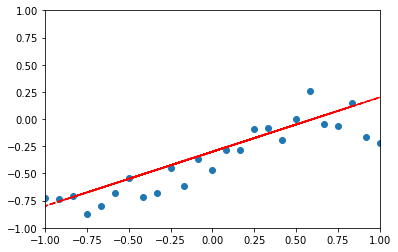

In [2]:
N = 25
noise = 0.2
xs = np.linspace(-1,1,N)
np.random.shuffle(xs)
actual_params = [-0.3, 0.5]
ys_actual = actual_params[0] + actual_params[1] * xs
ys = ys_actual + np.random.normal(0,noise,N)
Xs = xs.reshape((len(xs),1))

plt.xlim([-1,1])
plt.ylim([-1,1])
plt.scatter(xs, ys)
plt.plot(xs, ys_actual, 'r--')

In [3]:
class GaussianBayesianLeastSquares(object):
    def __init__(self, prior_mean, prior_covariance, beta):
        self.w = self.prior_mean = prior_mean
        self.S = self.prior_covariance = prior_covariance
        self.beta = beta
    
    def train(self, X, y):
        '''X is a (N x K) matrix of N examples, K features, and y is a Nx1 target vector'''
        assert(np.shape(X)[0] == len(y))
        N = np.shape(X)[0]
        X = np.c_[ np.ones((N,1)), X] # Add bias feature of all 1's. so X is now Nx(K+1)
        y = y.reshape((N,1))
        
        self.S = np.linalg.inv(np.linalg.inv(self.prior_covariance) + self.beta * np.dot(np.transpose(X), X))
        self.w = np.dot(self.S, np.dot(np.linalg.inv(self.prior_covariance), self.prior_mean) + \
                        self.beta * np.dot(np.transpose(X), y))
        return self
    
    def predict(self, X):
        assert(len(self.w) == (1 + np.shape(X)[1]))
        N = np.shape(X)[0]
        X = np.c_[ np.ones((N,1)), X]
        return np.dot(X, self.w)
    
class IsotropicGaussianBayesianLeastSquares(object):
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
    
    def train(self, X, y):
        '''X is a (N x K) matrix of N examples, K features, and y is a Nx1 target vector'''
        assert(np.shape(X)[0] == len(y))
        N, K = np.shape(X)[0], np.shape(X)[1]
        X = np.c_[ np.ones((N,1)), X] # Add bias feature of all 1's. so X is now Nx(K+1)
        y = y.reshape((N,1))
        
        phi = np.dot(np.transpose(X), X)
        (eigenvalues, _) = np.linalg.eig(phi)
        
        prev_alpha, prev_beta = self.alpha/2, self.beta/2
        i = 1
        while abs(self.alpha - prev_alpha) > 1e-3 and abs(self.beta - prev_beta) > 1e-3:
            print('Iteration #{:d}'.format(i))
            i+=1
            
            prev_alpha, prev_beta = self.alpha, self.beta
            
            gamma = (eigenvalues / (self.alpha + eigenvalues)).sum()

            self.S = np.linalg.inv(self.alpha * np.eye(K+1) + self.beta * phi)
            self.w = self.beta * np.dot(self.S, np.dot(np.transpose(X), y))
            
            self.alpha = gamma / np.dot(np.transpose(self.w), self.w)
            self.beta = (N - gamma) / np.square(y - np.dot(X, self.w)).sum()
        return self
    
    def predict(self, X):
        assert(len(self.w) == (1 + np.shape(X)[1]))
        N = np.shape(X)[0]
        X = np.c_[ np.ones((N,1)), X]
        return np.dot(X, self.w)

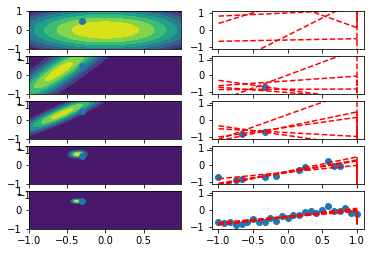

In [4]:
from scipy.stats import multivariate_normal as mvn_pdf
def plot_sample_lines(x_used, y_used, model, axes, num_samples=5):
    # draw from model's posterior distribution over weights and plot on axes
    if x_used is not None and y_used is not None:
        axes.scatter(x_used, y_used)

    axes.set_xlim([-1.1,1.1])
    axes.set_ylim([-1.1,1.1])

    xs = np.linspace(-1,1,100)
    xs = np.c_[ np.ones((len(xs),1)), xs ]
    for i in range(num_samples):
        params = np.random.multivariate_normal(model.w.flatten(), model.S)
        axes.plot(xs, xs.dot(params), 'r--')

def plot_parameter_space_contours(model, axes):
    # plot contour map of model's posterior distribution on axes
    x, y = np.mgrid[-1:1:.01, -1:1:.01]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    rv = mvn_pdf(model.w.flatten(), model.S)
    axes.contourf(x, y, rv.pdf(pos))
    axes.scatter(actual_params[0], actual_params[1])

def plot_2d_posteriors(X, y, alpha, beta, steps):
    assert(np.shape(X)[0] == len(y))
    N = np.shape(X)[0]
    K = np.shape(X)[1]
    
    prior_mean = np.zeros((K+1,1))
    prior_covariance = alpha * np.eye(K+1)
    steps = [0] + steps
    
    fig, axes = plt.subplots(len(steps), 2)
    
    model = GaussianBayesianLeastSquares(prior_mean, prior_covariance, beta)
    plot_parameter_space_contours(model, axes[0, 0])
    plot_sample_lines(None, None, model, axes[0, 1])
    
    for i in range(1,len(steps)):
        Xs = X[steps[i-1]:steps[i],:]
        ys = y[steps[i-1]:steps[i]]
        
        model = GaussianBayesianLeastSquares(prior_mean, prior_covariance, beta).train(Xs, ys)
        plot_parameter_space_contours(model, axes[i, 0])
        plot_sample_lines(X[:steps[i],:], y[:steps[i]], model, axes[i, 1])
        
        # update
        (prior_mean, prior_covariance, beta) = (model.w, model.S, model.beta)

plot_2d_posteriors(Xs, ys, 2.0, 25, [1,2,10,25])

Iteration #1
Iteration #2
Iteration #3
Iteration #4
Iteration #5
Iteration #6
Iteration #7
[[-0.37426949]
 [ 0.4651271 ]]
[[  8.61114554e-04   1.25785330e-19]
 [  1.25785330e-19   2.36912331e-03]]
[[ 4.29554837]] 46.2791146615


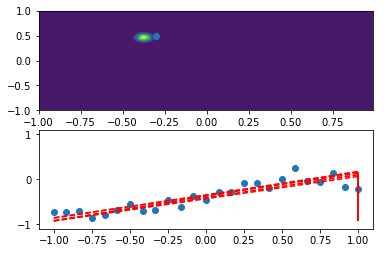

In [6]:
# try isotropic gaussian model
isotropic_model = IsotropicGaussianBayesianLeastSquares(1., 1.).train(Xs, ys)
print(isotropic_model.w)
print(isotropic_model.S)
print(isotropic_model.alpha, isotropic_model.beta)

fig, axes = plt.subplots(2, 1)
plot_parameter_space_contours(isotropic_model, axes[0])
plot_sample_lines(Xs, ys, isotropic_model, axes[1])